# COMPSCI 753 Assignment 1
Chase Robertson       
686249907  
crob873

# Datasets
The data is sourced from BBC News, and is categorised as tech or entertainment news. Datasets imported here have already been converted to vocabulary bitvectors, and are formatted as tab-delimited.

# Part 1: LSH Hash Tables

In [1]:
import random, time
import pandas as pd
import numpy as np
from sympy import sieve
from seaborn import heatmap, lineplot
from matplotlib import rcParams

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### a) Load and report dataframe shapes

In [2]:
bitvec_all = pd.read_csv("bbc/bitvector_all.csv", index_col=0,
                         delimiter="\t", header=None)
bitvec_query = pd.read_csv("bbc/bitvector_query.csv", index_col=0,
                           delimiter="\t", header=None)

# separate ID and label columns
all_x = bitvec_all.loc[:, :14927]
all_y = bitvec_all.loc[:, 14928]
query_x = bitvec_query.loc[:, :14927]
query_y = bitvec_query.loc[:, 14928]

In [3]:
print(all_x.shape, all_y.shape)
print(query_x.shape, query_y.shape)

(534, 14927) (534,)
(4, 14927) (4,)


There are 534 articles, each with 14,927 binary features and one string label.

### b) Construct family of MinHash functions

In [4]:
def generate_hash_functions(p, l, k):
    a, b = [1], [1]
    # ensure distinct values of a and b
    while set(a).intersection(b):
        a = random.sample(range(1, p), l*k)
        b = random.sample(range(0, p), l*k)
    return a, b


ndoc, n = all_x.shape

# choose prime number p > n
p = random.choice(list(sieve.primerange(n, n*2)))
a, b = generate_hash_functions(p, l=10, k=2)
        
for i, a_, b_ in zip(range(1,len(a)+1), a, b):
    print(f"h{i}(x)\t= ( ( x * {a_}\t+ {b_}\t) % {p} ) % {n}")

h1(x)	= ( ( x * 11731	+ 2436	) % 15107 ) % 14927
h2(x)	= ( ( x * 5777	+ 7897	) % 15107 ) % 14927
h3(x)	= ( ( x * 4381	+ 4384	) % 15107 ) % 14927
h4(x)	= ( ( x * 2630	+ 4497	) % 15107 ) % 14927
h5(x)	= ( ( x * 1474	+ 7753	) % 15107 ) % 14927
h6(x)	= ( ( x * 7210	+ 4640	) % 15107 ) % 14927
h7(x)	= ( ( x * 6307	+ 2255	) % 15107 ) % 14927
h8(x)	= ( ( x * 7424	+ 11978	) % 15107 ) % 14927
h9(x)	= ( ( x * 6219	+ 5134	) % 15107 ) % 14927
h10(x)	= ( ( x * 9020	+ 14176	) % 15107 ) % 14927
h11(x)	= ( ( x * 6069	+ 2896	) % 15107 ) % 14927
h12(x)	= ( ( x * 12580	+ 161	) % 15107 ) % 14927
h13(x)	= ( ( x * 4764	+ 1065	) % 15107 ) % 14927
h14(x)	= ( ( x * 6432	+ 4955	) % 15107 ) % 14927
h15(x)	= ( ( x * 8279	+ 1335	) % 15107 ) % 14927
h16(x)	= ( ( x * 12138	+ 1646	) % 15107 ) % 14927
h17(x)	= ( ( x * 2221	+ 3284	) % 15107 ) % 14927
h18(x)	= ( ( x * 9431	+ 6710	) % 15107 ) % 14927
h19(x)	= ( ( x * 14905	+ 9549	) % 15107 ) % 14927
h20(x)	= ( ( x * 12515	+ 4347	) % 15107 ) % 14927


### c) Construct LSH hash tables

In [5]:
# vectorised application of ax + b % p % n
def apply_hash(x, a, b, p, n):
    return ((np.outer(a, x) + np.array(b)[:, np.newaxis]) % p) % n
    
    
def get_signatures(documents, a, b, p, n):
    ndoc, nfeat = documents.shape
    
    signatures = pd.DataFrame(index=documents.index.copy(), columns=range(len(a)))

    for doc_idx in documents.index:
        feats = documents.loc[doc_idx]
        
        # select only those features with value 1
        feats = feats[feats != 0]
    
        minhashes = apply_hash(feats.index, a, b, p, n)
        signatures.loc[doc_idx] = np.min(minhashes, axis=1)

    return signatures


signatures = get_signatures(all_x, a, b, p, n)
signatures[:3]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,,,,,,,,,,,,,,,,,,
1,1,7,120,36,38,29,28,10,10,17,8,53,14,25,18,18,83,25,11,0
2,98,7,151,17,18,46,55,8,127,36,106,119,84,445,39,10,112,525,137,75
3,15,1,143,36,2,91,12,64,27,137,80,100,86,33,143,18,75,14,179,39


Now that we have a minhash signature for each document, we can use m general hash functions to assign each to a bucket, with collisions being likely only for signatures which match.

In [6]:
def general_hash_functions(p, l):
    c, d, e = [1], [1], [1]
    # ensure c, d, e do not share any values
    while set(c).intersection(d).intersection(e):
        c = random.sample(range(1, p), l)
        d = random.sample(range(1, p), l)
        e = random.sample(range(0, p), l)
    return c, d, e


# scalar application of general hash function
def apply_hash2(x, c, d, e, p, m):
    return ((c*x[0] + d*x[1] + e) % p) % m


def get_bucket_bands(signatures, c, d, e, p, m, l, k):
    bucket_bands = [[[] for j in range(m)] for i in range(l)]
    
    for i in signatures.index:
        sig = signatures.loc[i]
        
        # separate signature into k-length bands
        sig_band = np.stack([sig[x:x+k] for x in range(0, l*k, k)])
        for j in range(l):
            for o in range(l):
                # apply hash to determine which bucket doc belongs in
                bucket = apply_hash2(sig_band[o], c[j], d[j], e[j], p, m)
                bucket_bands[j][bucket].append(i)
                
    return bucket_bands


# choose m between n and p
m = (n + p) // 2

# get randomised coefficients of general hash function
c, d, e = general_hash_functions(p, l=10)

# get bucket bands given document signatures
bucket_bands = get_bucket_bands(signatures, c, d, e, p, m, l=10, k=2)
bucket_bands[0][:5]

[[], [], [], [], []]

Now that we have 10 bands with m buckets each, we can consider those buckets which contain multiple document ID's as colliding documents.

<AxesSubplot:>

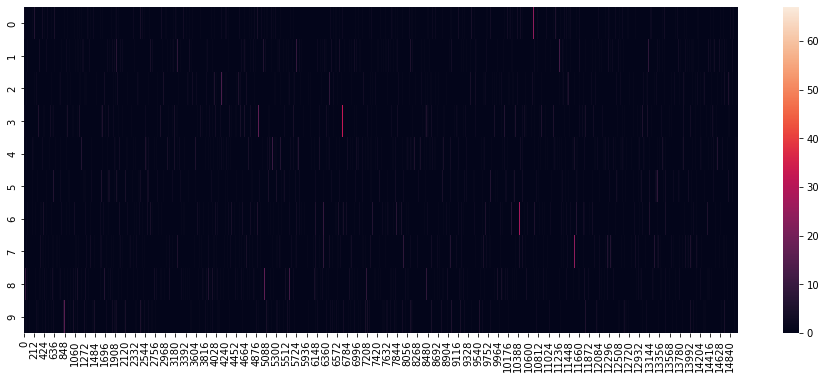

In [7]:
def get_collisions(bucket_bands, m):
    n_bands = len(bucket_bands)
    collisions = np.zeros([n_bands, m], dtype=int)
    for i in range(n_bands):
        for j in range(m):
            collisions[i, j] = len(bucket_bands[i][j])
    return collisions

collisions = get_collisions(bucket_bands, m)

rcParams['figure.figsize'] = 16, 6
heatmap(collisions)

Due to m's large size, document signature collisions are quite rare, so the heatmap is mostly dark except for a few hot spots.

# Part 2: Nearest Neighbor Search

### a) Query LSH for top 10 matches with each test document

In [8]:
def est_jaccard(x, y):
    return sum([x_ == y_ for x_, y_ in zip(x, y)]) / len(x)


# yield the full set of documents which collide with the given query signatures in any band
def query_collisions(bucket_bands, query_sigs, p, m, l, k):
    collisions = {i: set() for i in query_sigs.index}
    for q in query_sigs.index:
        sig = query_sigs.loc[q]
        sig_bands = np.stack([sig[x:x+k] for x in range(0, l*k, k)])
        for j in range(l):
            for o in range(l):
                bucket = apply_hash2(sig_bands[o], c[j], d[j], e[j], p, m)
                collisions[q] = collisions[q].union(set(bucket_bands[j][bucket]))
    return collisions


# yield the 10 nearest documents of each query, by jaccard similarity between signatures
def query_est_jaccards(query_sigs, query_cols, signatures, all_y, top_n=10):
    est_jaccards = {i: {} for i in query_sigs.index}
    
    for i in query_sigs.index:
        for match_id in query_cols[i]:
            est_dist = est_jaccard(query_sigs.loc[i], signatures.loc[match_id])
            if est_dist not in est_jaccards[i]:
                est_jaccards[i][est_dist] = set()
            # add matched document id to this distance's associated set of documents
            est_jaccards[i][est_dist].add(match_id) 
    
    nearest = {i: [] for i in query_sigs.index}
    
    for i, dic in est_jaccards.items():
        # add documents in descending order of jaccard distance between signatures
        dists = reversed(sorted(dic.keys()))
        for dist in dists:
            for match_id in dic[dist]:
                if len(nearest[i]) < top_n:
                    nearest[i].append([match_id, dist, all_y[match_id]])
    return nearest


# get minhash signatures of each query document
query_sigs = get_signatures(query_x, a, b, p, n)

t1 = time.time()
# get documents which collide with query documents in some band/bucket
query_cols = query_collisions(bucket_bands, query_sigs, p, m, l=10, k=2)

# get ten nearest colliding documents by jaccard similarity between signatures
lsh_matches = query_est_jaccards(query_sigs, query_cols, signatures, all_y)
t2 = time.time()

lsh_matches

{531: [[531, 1.0, 'entertainment'],
  [392, 0.15, 'entertainment'],
  [491, 0.15, 'entertainment'],
  [174, 0.15, 'entertainment'],
  [406, 0.15, 'entertainment'],
  [412, 0.15, 'entertainment'],
  [37, 0.1, 'entertainment'],
  [38, 0.1, 'tech'],
  [201, 0.1, 'tech'],
  [11, 0.1, 'entertainment']],
 532: [[532, 1.0, 'entertainment'],
  [437, 0.25, 'entertainment'],
  [352, 0.2, 'entertainment'],
  [1, 0.1, 'tech'],
  [4, 0.1, 'entertainment'],
  [36, 0.1, 'tech'],
  [459, 0.1, 'entertainment'],
  [48, 0.1, 'entertainment'],
  [212, 0.1, 'entertainment'],
  [153, 0.1, 'tech']],
 533: [[533, 1.0, 'tech'],
  [229, 0.3, 'tech'],
  [149, 0.3, 'tech'],
  [226, 0.25, 'tech'],
  [325, 0.25, 'tech'],
  [271, 0.25, 'tech'],
  [402, 0.25, 'tech'],
  [147, 0.25, 'tech'],
  [407, 0.25, 'tech'],
  [283, 0.25, 'tech']],
 534: [[534, 1.0, 'tech'],
  [330, 0.25, 'tech'],
  [512, 0.2, 'tech'],
  [67, 0.2, 'tech'],
  [390, 0.2, 'tech'],
  [492, 0.2, 'tech'],
  [526, 0.2, 'tech'],
  [260, 0.15, 'tech'],
 

### b) Report full Jaccard similarity of query documents

In [9]:
def full_jaccard(x, y):
    return sum(np.logical_and(x, y)) / sum(np.logical_or(x, y))


def query_full_jaccards(query, docs, top_n=10):
    jaccards = {i: {} for i in query.index}
    for i in query.index:
        for j in docs.index:
            dist = full_jaccard(query.loc[i], docs.loc[j])
            if dist not in jaccards[i]:
                jaccards[i][dist] = set()
            jaccards[i][dist].add(j) 
    
    nearest = {i: [] for i in query.index}
    for i, dic in jaccards.items():
        for dist in reversed(sorted(dic.keys())):
            for match_id in dic[dist]:
                if len(nearest[i]) < top_n:
                    nearest[i].append([match_id, round(dist, 3), all_y[match_id]])
    return nearest


t3 = time.time()
# get top ten full jaccard similarity matches for each query document
jaccard_matches = query_full_jaccards(query_x, all_x)
t4 = time.time()

jaccard_matches

{531: [[531, 1.0, 'entertainment'],
  [145, 0.197, 'entertainment'],
  [70, 0.168, 'entertainment'],
  [314, 0.165, 'entertainment'],
  [130, 0.115, 'entertainment'],
  [412, 0.072, 'entertainment'],
  [317, 0.065, 'entertainment'],
  [503, 0.062, 'entertainment'],
  [35, 0.062, 'entertainment'],
  [321, 0.06, 'entertainment']],
 532: [[532, 1.0, 'entertainment'],
  [419, 0.094, 'entertainment'],
  [42, 0.094, 'entertainment'],
  [520, 0.092, 'entertainment'],
  [524, 0.092, 'tech'],
  [251, 0.091, 'entertainment'],
  [197, 0.091, 'entertainment'],
  [501, 0.09, 'tech'],
  [221, 0.09, 'tech'],
  [125, 0.089, 'tech']],
 533: [[533, 1.0, 'tech'],
  [64, 0.167, 'tech'],
  [306, 0.166, 'tech'],
  [484, 0.139, 'tech'],
  [117, 0.139, 'tech'],
  [408, 0.137, 'tech'],
  [275, 0.137, 'tech'],
  [495, 0.136, 'tech'],
  [132, 0.127, 'tech'],
  [464, 0.127, 'tech']],
 534: [[534, 1.0, 'tech'],
  [211, 0.123, 'tech'],
  [324, 0.111, 'tech'],
  [330, 0.111, 'tech'],
  [371, 0.111, 'tech'],
  [183, 

### c) Compare LSH query time to full Jaccard comparison time

In [10]:
# take average of total time to query and jaccard the 4 docs
avg_lsh_time = 1000 * (t2-t1) / len(query_y)
avg_jaccard_time = 1000 * (t4-t3) / len(query_y)

print(f"Avg LSH query time: {avg_lsh_time:.0f}ms")
print(f"Avg Jaccard comparison time: {avg_jaccard_time:.0f}ms")

Avg LSH query time: 9ms
Avg Jaccard comparison time: 2013ms


The LSH query time is significantly less than the full Jaccard similarity search: LSH is 2 orders of magnitude faster. The difference in performance remains to be seen, but this difference in speed makes a compelling argument for use of LSH.

# Part 3: Search Quality Evaluation
### a) Investigate impact of hash size k

In [11]:
def F1_score(lsh_matches, jaccard_matches):
    # extract document IDs from match lists
    estimated = {match[0] for match in lsh_matches}
    ground_truth = {match[0] for match in jaccard_matches}
    tp = len(estimated & ground_truth)
    fp = len(estimated - ground_truth)
    fn = len(ground_truth - estimated)
    return tp / (tp + ((fp + fn) / 2))

In [12]:
scores = []
K = [2, 4, 8]
for k in K:
    a, b = generate_hash_functions(p, l=10, k=k)
    signatures = get_signatures(all_x, a, b, p, n)
    
    c, d, e = general_hash_functions(p, l=10)
    bucket_bands = get_bucket_bands(signatures, c, d, e, p, m, l=10, k=k)
    
    collisions = get_collisions(bucket_bands, m)
    
    query_sigs = get_signatures(query_x, a, b, p, n)  
    
    t1 = time.time()
    query_cols = query_collisions(bucket_bands, query_sigs, p, m, l=10, k=k)
    lsh_matches = query_est_jaccards(query_sigs, query_cols, signatures, all_y)
    t2 = time.time()
    
    f1 = np.mean([F1_score(jaccard_matches[i], lsh_matches[i]) for i in query_x.index])
    scores.append(f1)
    
    avg_time = 1000 * (t2-t1) / len(query_y)
    print(f"k={k}: Avg F1 {f1:.4f}; Avg query time {avg_time:.0f}ms")

k=2: Avg F1 0.2250; Avg query time 7ms
k=4: Avg F1 0.1750; Avg query time 7ms
k=8: Avg F1 0.3250; Avg query time 9ms


<AxesSubplot:>

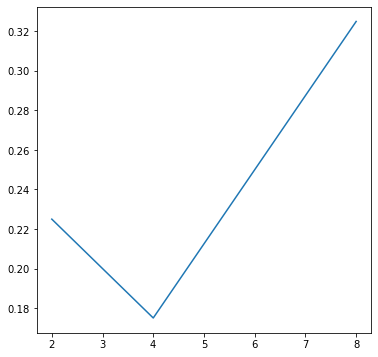

In [13]:
rcParams['figure.figsize'] = 6, 6
lineplot(x=K, y=scores)

### b) How to tune k to increase F1 and reduce query time.

The average F1 score seems to consistently favor k=8, and the average query time of k=8 is not significantly longer than other values of k. Therefore, I would prefer to use 8 or higher as the value of k.